In [6]:
!pip install lifelines tqdm --quiet
# --- Repo + path setup ---

import os, sys

# 1) Clone repo if it doesn't exist
if not os.path.exists('/content/bdh_challenge_2025'):
    %cd /content
    !git clone https://github.com/arionandrei2000/bdh_challenge_2025.git

# 2) Move into repo root
%cd /content/bdh_challenge_2025
print("PWD:", os.getcwd())
print("Repo contents:", os.listdir())

# 3) src is under notebooks/src, so add that parent folder to sys.path
src_parent = "/content/bdh_challenge_2025/notebooks"
if src_parent not in sys.path:
    sys.path.append(src_parent)

print("sys.path updated; ready to import src.")


/content
Cloning into 'bdh_challenge_2025'...
remote: Enumerating objects: 117, done.
remote: Counting objects: 100% (117/117), done.
remote: Compressing objects: 100% (108/108), done.
remote: Total 117 (delta 20), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (117/117), 810.07 KiB | 6.98 MiB/s, done.
Resolving deltas: 100% (20/20), done.
/content/bdh_challenge_2025
PWD: /content/bdh_challenge_2025
Repo contents: ['README.md', '.git', 'notebooks']
sys.path updated; ready to import src.


In [8]:

# 02) Mount GDrive
# This lets us store large TCGA data in Drive so it persists across sessions

from google.colab import drive
drive.mount('/content/drive')

print(" Google Drive mounted at /content/drive")
# 03) Project Paths in Google Drive

from pathlib import Path
import os

# Main project root on Google Drive
PROJECT_ROOT = Path("/content/drive/MyDrive/bdh_challenge_2025_data")
PROJECT_ROOT.mkdir(exist_ok=True)

# Data directories

# Generic data directory
DATA_DIR = PROJECT_ROOT / "data"
DATA_DIR.mkdir(exist_ok=True)

# Directory where raw TCGA STAR count files will be stored
RNA_DIR = PROJECT_ROOT / "tcga_rna"
RNA_DIR.mkdir(exist_ok=True)

# Directory where processed matrices, tokenized data, embeddings
PROCESSED_DIR = PROJECT_ROOT / "processed"
PROCESSED_DIR.mkdir(exist_ok=True)

print("Project root :", PROJECT_ROOT)
print("DATA_DIR     :", DATA_DIR)
print("RNA_DIR      :", RNA_DIR)
print("PROCESSED_DIR:", PROCESSED_DIR)




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 Google Drive mounted at /content/drive
Project root : /content/drive/MyDrive/bdh_challenge_2025_data
DATA_DIR     : /content/drive/MyDrive/bdh_challenge_2025_data/data
RNA_DIR      : /content/drive/MyDrive/bdh_challenge_2025_data/tcga_rna
PROCESSED_DIR: /content/drive/MyDrive/bdh_challenge_2025_data/processed


In [19]:
import os
from pathlib import Path

import numpy as np
import pandas as pd

from tqdm import tqdm

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.decomposition import PCA, NMF
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    confusion_matrix,
    classification_report
)

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from lifelines.utils import concordance_index
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)



In [12]:
from pathlib import Path
import json
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
)

from lifelines import CoxPHFitter
from IPython.display import display

# 0) Paths

PROJECT_ROOT  = Path("/content/drive/MyDrive/bdh_challenge_2025_data")
PROCESSED_DIR = PROJECT_ROOT / "processed"

EXPR_FILE = PROCESSED_DIR / "tcga_tpm_like_log10_bulkrnabert_aligned.parquet"
CLIN_FILE = PROCESSED_DIR / "tcga_clinical_bulkrnabert_cohorts.parquet"

RANDOM_SEED = 1234

# 1) Load + align expression + clinical

expr = pd.read_parquet(EXPR_FILE)
clinical = pd.read_parquet(CLIN_FILE)

expr.index.name = "sample_id"
clinical.index.name = "sample_id"

common = expr.index.intersection(clinical.index)
expr = expr.loc[common].sort_index()
clinical = clinical.loc[common].sort_index()

print("Expression:", expr.shape)
print("Clinical  :", clinical.shape)

# 2) Build 5-cohort label mapping

five_map = {
    "BRCA": "BRCA",
    "BLCA": "BLCA",
    "LUAD": "LUAD",
    "UCEC": "UCEC",
    "GBM":  "GBMLGG",
    "LGG":  "GBMLGG",
}

clinical["cohort_5"] = clinical["cohort"].map(five_map)
df_5 = clinical.dropna(subset=["cohort_5"]).copy()
df_5["cohort_5"] = df_5["cohort_5"].astype("category")
df_5["cohort_5_idx"] = df_5["cohort_5"].cat.codes

expr_5 = expr.loc[df_5.index]

print("\n--- 5-cohort counts ---")
print(df_5["cohort_5"].value_counts())

# 3) Survival subset (pan-cancer)


surv_df = clinical.dropna(subset=["survival_time", "event"]).copy()
expr_surv = expr.loc[surv_df.index]

print("\nSurvival subset shape:", expr_surv.shape)

# 4) Helper: save splits as JSON

def save_split(path, **arrays):
    payload = {k: list(v) for k, v in arrays.items()}
    with open(path, "w") as f:
        json.dump(payload, f)

# 5) Create + save splits

# 5-cohort split (stratified)
train_5, test_5 = train_test_split(
    df_5.index.to_numpy(),
    test_size=0.2,
    random_state=RANDOM_SEED,
    stratify=df_5["cohort_5"]
)
save_split(PROCESSED_DIR / "splits_5cohort.json",
           train_ids=train_5, test_ids=test_5)

# Pan-cancer classification split (all cohorts)
train_pan, test_pan = train_test_split(
    clinical.index.to_numpy(),
    test_size=0.2,
    random_state=RANDOM_SEED,
    stratify=clinical["cohort"]
)
save_split(PROCESSED_DIR / "splits_pancancer.json",
           train_ids=train_pan, test_ids=test_pan)

# Pan-cancer survival split (no stratify)
train_surv, test_surv = train_test_split(
    surv_df.index.to_numpy(),
    test_size=0.2,
    random_state=RANDOM_SEED,
)
save_split(PROCESSED_DIR / "splits_survival_pancancer.json",
           train_ids=train_surv, test_ids=test_surv)

print("\nSaved splits:")
for p in PROCESSED_DIR.glob("splits_*.json"):
    print(" •", p.name)

# 6) Helper to load splits + build X/y

def load_split(path: Path):
    with open(path) as f:
        d = json.load(f)
    return np.array(d["train_ids"]), np.array(d["test_ids"])


def get_Xy(expr_df, label_series, train_ids, test_ids):
    X_train = expr_df.loc[train_ids].values
    y_train = label_series.loc[train_ids].values

    X_test = expr_df.loc[test_ids].values
    y_test = label_series.loc[test_ids].values

    return X_train, y_train, X_test, y_test



Expression: (3385, 19062)
Clinical  : (3385, 12)

--- 5-cohort counts ---
cohort_5
BRCA      1095
GBMLGG     809
UCEC       557
LUAD       518
BLCA       406
Name: count, dtype: int64

Survival subset shape: (3351, 19062)

Saved splits:
 • splits_5cohort.json
 • splits_pancancer.json
 • splits_survival_pancancer.json



 Running 5-cohort PCA+SVM

--- 5-cohort metrics ---
Accuracy   : 0.9940915805022157
Macro F1   : 0.992906474859365
Weighted F1: 0.9940961657501629

Classification report:
              precision    recall  f1-score   support

        BLCA       0.98      1.00      0.99        81
        BRCA       1.00      1.00      1.00       219
      GBMLGG       1.00      1.00      1.00       162
        LUAD       0.99      0.99      0.99       104
        UCEC       1.00      0.98      0.99       111

    accuracy                           0.99       677
   macro avg       0.99      0.99      0.99       677
weighted avg       0.99      0.99      0.99       677


Metrics summary table:


,Accuracy,Macro F1,Weighted F1
PCA(256) + SVM (5 cohorts),0.994092,0.992906,0.994096


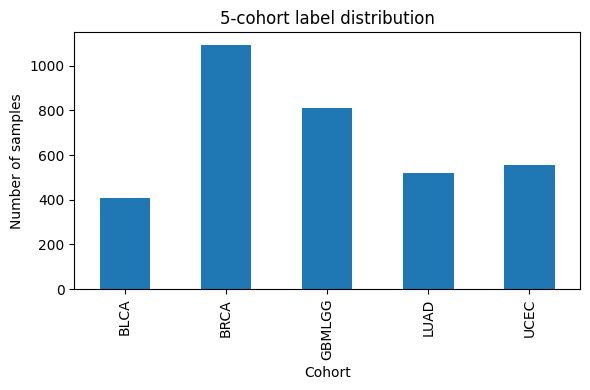

<Figure size 500x500 with 0 Axes>

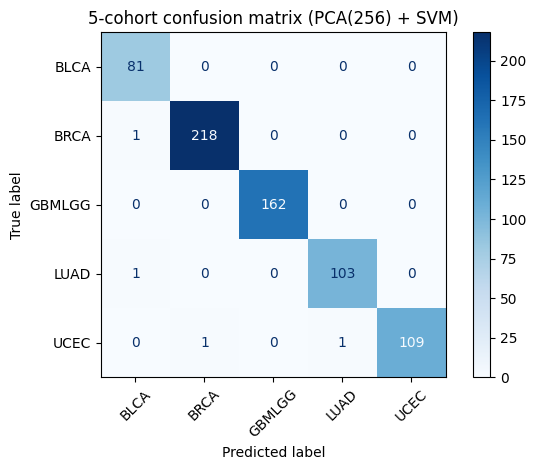


Computing 2D PCA projection for visualization...


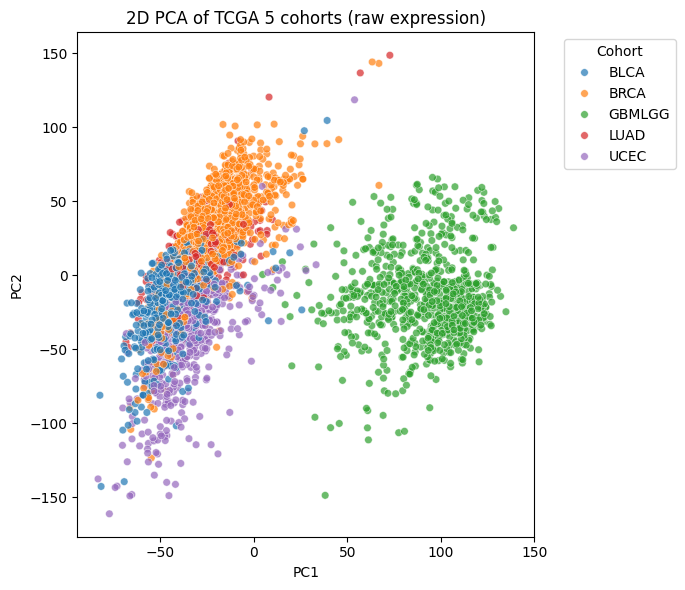

In [20]:

# 7) 5-cohort PCA + SVM baseline

print("\n Running 5-cohort PCA+SVM")
split_5_path = PROCESSED_DIR / "splits_5cohort.json"
train_ids_5, test_ids_5 = load_split(split_5_path)

train_ids_5 = np.array([s for s in train_ids_5 if s in expr_5.index])
test_ids_5  = np.array([s for s in test_ids_5  if s in expr_5.index])

X_train_5, y_train_5, X_test_5, y_test_5 = get_Xy(
    expr_5, df_5["cohort_5"], train_ids_5, test_ids_5
)

clf_5 = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=256, random_state=1234)),
    ("svm", SVC(
        kernel="rbf",
        C=10.0,
        gamma="scale",
        class_weight="balanced",
        random_state=1234,
    ))
])

clf_5.fit(X_train_5, y_train_5)
y_pred_5 = clf_5.predict(X_test_5)

# ---------------------------------------------------------------------
# 7.3 Metrics + classification report
# ---------------------------------------------------------------------
acc_5        = accuracy_score(y_test_5, y_pred_5)
macro_f1_5   = f1_score(y_test_5, y_pred_5, average="macro")
weighted_f1_5= f1_score(y_test_5, y_pred_5, average="weighted")

print("\n--- 5-cohort metrics ---")
print("Accuracy   :", acc_5)
print("Macro F1   :", macro_f1_5)
print("Weighted F1:", weighted_f1_5)

print("\nClassification report:")
print(classification_report(y_test_5, y_pred_5))

# Nice compact metrics summary table (useful for the BDH report)
metrics_5 = pd.DataFrame(
    {
        "Accuracy":   [acc_5],
        "Macro F1":   [macro_f1_5],
        "Weighted F1":[weighted_f1_5],
    },
    index=["PCA(256) + SVM (5 cohorts)"],
)
print("\nMetrics summary table:")
display(metrics_5)

# ---------------------------------------------------------------------
# 7.4 Label distribution plot (matches the style of Figure 5 in paper)
# ---------------------------------------------------------------------
plt.figure(figsize=(6,4))
df_5["cohort_5"].value_counts().sort_index().plot(kind="bar")
plt.title("5-cohort label distribution")
plt.xlabel("Cohort")
plt.ylabel("Number of samples")
plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------
# 7.5 Confusion matrix for PCA+SVM baseline
# ---------------------------------------------------------------------
cm = confusion_matrix(y_test_5, y_pred_5, labels=np.unique(y_test_5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test_5))

plt.figure(figsize=(5,5))
disp.plot(cmap="Blues", values_format="d")
plt.title("5-cohort confusion matrix (PCA(256) + SVM)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------
# 7.6 2D PCA visualization of raw expression (sanity check / nice figure)
#     This is *just* for visualization; not used in the SVM pipeline.
# ---------------------------------------------------------------------
print("\nComputing 2D PCA projection for visualization...")

scaler_vis = StandardScaler()
X_scaled_5 = scaler_vis.fit_transform(expr_5.loc[df_5.index])  # all 5 cohorts

pca_vis = PCA(n_components=2, random_state=1234)
X_pca_2 = pca_vis.fit_transform(X_scaled_5)

pca_vis_df = pd.DataFrame(
    {
        "PC1": X_pca_2[:, 0],
        "PC2": X_pca_2[:, 1],
        "cohort_5": df_5["cohort_5"].values,
    },
    index=df_5.index,
)

plt.figure(figsize=(7,6))
sns.scatterplot(
    data=pca_vis_df,
    x="PC1",
    y="PC2",
    hue="cohort_5",
    alpha=0.7,
    s=30,
)
plt.title("2D PCA of TCGA 5 cohorts (raw expression)")
plt.legend(title="Cohort", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

In [15]:
# 8) Pan-cancer PCA + SVM baseline


print("\n=== Running Pan-Cancer PCA+SVM ===")

split_pan_path = PROCESSED_DIR / "splits_pancancer.json"
train_ids_pan, test_ids_pan = load_split(split_pan_path)

train_ids_pan = np.array([s for s in train_ids_pan if s in expr.index])
test_ids_pan  = np.array([s for s in test_ids_pan  if s in expr.index])

X_train_pan, y_train_pan, X_test_pan, y_test_pan = get_Xy(
    expr, clinical["cohort"], train_ids_pan, test_ids_pan
)

clf_pan = Pipeline([
    ("scaler", StandardScaler()),
    ("pca",  PCA(n_components=128, random_state=42)),
    ("svm",  SVC(
        kernel="rbf",
        C=10.0,
        gamma="scale",
        class_weight="balanced",
        random_state=42,
    ))
])

clf_pan.fit(X_train_pan, y_train_pan)
y_pred_pan = clf_pan.predict(X_test_pan)

print("\n--- Pan-cancer metrics ---")
print("Accuracy   :", accuracy_score(y_test_pan, y_pred_pan))
print("Macro F1   :", f1_score(y_test_pan, y_pred_pan, average="macro"))
print("Weighted F1:", f1_score(y_test_pan, y_pred_pan, average="weighted"))

print("\nClassification report:")
print(classification_report(y_test_pan, y_pred_pan))




=== Running Pan-Cancer PCA+SVM ===

--- Pan-cancer metrics ---
Accuracy   : 0.9955686853766618
Macro F1   : 0.9945673700883179
Weighted F1: 0.9955840445414126

Classification report:
              precision    recall  f1-score   support

        BLCA       0.98      1.00      0.99        81
        BRCA       1.00      1.00      1.00       219
         GBM       0.98      1.00      0.99        59
         LGG       1.00      0.99      1.00       103
        LUAD       1.00      0.99      1.00       104
        UCEC       1.00      1.00      1.00       111

    accuracy                           1.00       677
   macro avg       0.99      1.00      0.99       677
weighted avg       1.00      1.00      1.00       677



In [ ]:
# 9) Pan-cancer survival (CoxPH on PCA)

print("\n=== Running Pan-Cancer Survival (CoxPH+PCA) ===")

split_surv_path = PROCESSED_DIR / "splits_survival_pancancer.json"
train_ids_surv, test_ids_surv = load_split(split_surv_path)

train_ids_surv = np.array([s for s in train_ids_surv if s in expr_surv.index])
test_ids_surv  = np.array([s for s in test_ids_surv  if s in expr_surv.index])

# Build features
X_train_surv = expr_surv.loc[train_ids_surv].values
X_test_surv  = expr_surv.loc[test_ids_surv].values

y_time_train  = surv_df.loc[train_ids_surv, "survival_time"].values
y_event_train = surv_df.loc[train_ids_surv, "event"].values.astype(int)

y_time_test  = surv_df.loc[test_ids_surv, "survival_time"].values
y_event_test = surv_df.loc[test_ids_surv, "event"].values.astype(int)

# Scale + PCA
scaler = StandardScaler()
X_train_surv_scaled = scaler.fit_transform(X_train_surv)
X_test_surv_scaled  = scaler.transform(X_test_surv)

pca_surv = PCA(n_components=32, random_state=42)
X_train_surv_pca = pca_surv.fit_transform(X_train_surv_scaled)
X_test_surv_pca  = pca_surv.transform(X_test_surv_scaled)

cols = [f"PC{i+1}" for i in range(X_train_surv_pca.shape[1])]

train_cox_df = pd.DataFrame(X_train_surv_pca, index=train_ids_surv, columns=cols)
train_cox_df["survival_time"] = y_time_train
train_cox_df["event"] = y_event_train

test_cox_df = pd.DataFrame(X_test_surv_pca, index=test_ids_surv, columns=cols)
test_cox_df["survival_time"] = y_time_test
test_cox_df["event"] = y_event_test

# Fit Cox
cph = CoxPHFitter()
cph.fit(train_cox_df, duration_col="survival_time", event_col="event")

print("\n--- CoxPH Summary ---")
display(cph.summary)

# Concordance
c_train = cph.concordance_index_
c_test  = cph.score(test_cox_df, scoring_method="concordance_index")

print("\n--- Concordance Index ---")
print("Train:", c_train)
print("Test :", c_test)